<a href="https://colab.research.google.com/github/sushily1997/ML_Assignments/blob/main/Topic_Modeling_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Let's load the libraries 
import nltk   # for text manipulation
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
'''
Loading Gensim and nltk libraries
'''
# pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(400)

In [ ]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True)
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True)

In [ ]:
print(list(newsgroups_train.target_names))
# There are 20 targets in the data set — ‘alt.atheism’ etc

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Looking visually we can say that this data set has a few broad topics like:

* Science
* Politics
* Sports
* Religion
* Technology etc


#**Extracting Topics using LDA in Python**
##**1. Preprocessing the raw text**
This involves the following:

* Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All stopwords are removed.
*  Words are lemmatized — words in third person are changed to first person and  verbs in past and future tenses are changed into present.
* Words are stemmed — words are reduced to their root form.

We use the NLTK and gensim libraries to perform the preprocessing

####**Lemmatizer Example**
Before preprocessing our dataset, let's first look at an lemmatizing example. What would be the output if we lemmatized the word 'went':

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
print(WordNetLemmatizer().lemmatize('went', pos = 'v')) # past tense to present tense


go


####**Stemmer Example**
Let's also look at a stemming example. Let's throw a number of words at the stemmer and see how it deals with each one:

In [ ]:
stemmer = SnowballStemmer("english")
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [ ]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [ ]:
'''
Preview a document after preprocessing
'''
document_num = 50
doc_sample = 'This disk has failed many times. I would like to get it replaced.'

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['This', 'disk', 'has', 'failed', 'many', 'times.', 'I', 'would', 'like', 'to', 'get', 'it', 'replaced.']


Tokenized and lemmatized document: 
['disk', 'fail', 'time', 'like', 'replac']


Let's now preprocess all the news headlines we have. To do that, we iterate over the list of documents in our training sample



In [ ]:
processed_docs = []

for doc in newsgroups_train.data:
    processed_docs.append(preprocess(doc))


In [ ]:
'''
Preview 'processed_docs'
'''
print(processed_docs[:2])

[['lerxst', 'thing', 'subject', 'nntp', 'post', 'host', 'organ', 'univers', 'maryland', 'colleg', 'park', 'line', 'wonder', 'enlighten', 'door', 'sport', 'look', 'late', 'earli', 'call', 'bricklin', 'door', 'small', 'addit', 'bumper', 'separ', 'rest', 'bodi', 'know', 'tellm', 'model', 'engin', 'spec', 'year', 'product', 'histori', 'info', 'funki', 'look', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst'], ['guykuo', 'carson', 'washington', 'subject', 'clock', 'poll', 'final', 'summari', 'final', 'clock', 'report', 'keyword', 'acceler', 'clock', 'upgrad', 'articl', 'shelley', 'qvfo', 'innc', 'organ', 'univers', 'washington', 'line', 'nntp', 'post', 'host', 'carson', 'washington', 'fair', 'number', 'brave', 'soul', 'upgrad', 'clock', 'oscil', 'share', 'experi', 'poll', 'send', 'brief', 'messag', 'detail', 'experi', 'procedur', 'speed', 'attain', 'rat', 'speed', 'card', 'adapt', 'heat', 'sink', 'hour', 'usag', 'floppi', 'disk', 'function', 'floppi', 'especi', 'request', 'summar', 'day',

##**Step 3: Bag of words on the dataset**
Now let's create a dictionary from 'processed_docs' containing the number of times a word appears in the training set. To do that, let's pass processed_docs to gensim.corpora.Dictionary() and call it 'dictionary'.

Prior to topic modelling, we convert the tokenized and lemmatized text to a bag of words — which you can think of as a dictionary where the key is the word and value is the number of times that word occurs in the entire corpus.

We can further filter words that occur very few times or occur very frequently.

Now for each pre-processed document we use the dictionary object just created to convert that document into a bag of words. i.e for each document we create a dictionary reporting how many words and how many times those words appear.




In [ ]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [ ]:
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 addit
1 bodi
2 bricklin
3 bring
4 bumper
5 call
6 colleg
7 door
8 earli
9 engin
10 enlighten


###**Gensim filter_extremes**
filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

Filter out tokens that appear in

* less than no_below documents (absolute number) or
* more than no_above documents (fraction of total corpus size, not absolute number).
* after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).

In [ ]:
'''
OPTIONAL STEP
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

###**Gensim doc2bow**
####**doc2bow(document)**
Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

In [ ]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


In [ ]:
'''
Preview BOW for our sample preprocessed document
'''
document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 18 ("rest") appears 1 time.
Word 166 ("clear") appears 1 time.
Word 336 ("refer") appears 1 time.
Word 350 ("true") appears 1 time.
Word 391 ("technolog") appears 1 time.
Word 437 ("christian") appears 1 time.
Word 453 ("exampl") appears 1 time.
Word 476 ("jew") appears 1 time.
Word 480 ("lead") appears 1 time.
Word 482 ("littl") appears 3 time.
Word 520 ("wors") appears 2 time.
Word 721 ("keith") appears 3 time.
Word 732 ("punish") appears 1 time.
Word 803 ("california") appears 1 time.
Word 859 ("institut") appears 1 time.
Word 917 ("similar") appears 1 time.
Word 990 ("allan") appears 1 time.
Word 991 ("anti") appears 1 time.
Word 992 ("arriv") appears 1 time.
Word 993 ("austria") appears 1 time.
Word 994 ("caltech") appears 2 time.
Word 995 ("distinguish") appears 1 time.
Word 996 ("german") appears 1 time.
Word 997 ("germani") appears 3 time.
Word 998 ("hitler") appears 1 time.
Word 999 ("livesey") appears 2 time.
Word 1000 ("motto") appears 2 time.
Word 1001 ("order") appear

#**Embeddings**
The very first step we have to do is converting the documents to numerical data. We use BERT for this purpose as it extracts different embeddings based on the context of the word. Not only that, there are many pre-trained models available ready to be used.

How you generate the BERT embeddings for a document is up to you. However, I prefer to use the sentence-transformers package as the resulting embeddings have shown to be of high quality and typically work quite well for document-level embeddings.

Install the package with pip install sentence-transformers before generating the document embeddings. If you run into issues installing this package, then it is worth installing Pytorch first.

Then, run the following code to transform your documents in 512-dimensional vectors:

In [ ]:
pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.4 MB/s 
     |████████████████████████████████| 4.9 MB 25.1 MB/s 
     |████████████████████████████████| 1.3 MB 53.7 MB/s 
     |████████████████████████████████| 120 kB 58.8 MB/s 
     |████████████████████████████████| 6.6 MB 22.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=41355b0a39e68eb96dbbfc1ea016489ff04d1b23eee468e4ae5a0237c5419d19
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
%%time
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

CPU times: user 1h 44s, sys: 20.8 s, total: 1h 1min 5s
Wall time: 1h 53s


We are using Distilbert as it gives a nice balance between speed and performance. The package has several multi-lingual models available for you to use.

NOTE: Since transformer models have a token limit, you might run into some errors when inputting large documents. In that case, you could consider splitting documents into paragraphs.

#**Clustering**
We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.

###**UMAP**
Out of the few dimensionality reduction algorithms, UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.

Install the package with pip install umap-learn before we lower the dimensionality of the document embeddings. We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can play around with these values to optimize for your topic creation. Note that a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results.

In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

###**HDBSAN**
After having reduced the dimensionality of the documents embeddings to 5, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

Install the package with pip install hdbscan then create the clusters:



In [ ]:
pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

Great! We now have clustered similar documents together which should represent the topics that they consist of. To visualize the resulting clusters we can further reduce the dimensionality to 2 and visualize the outliers as grey points:

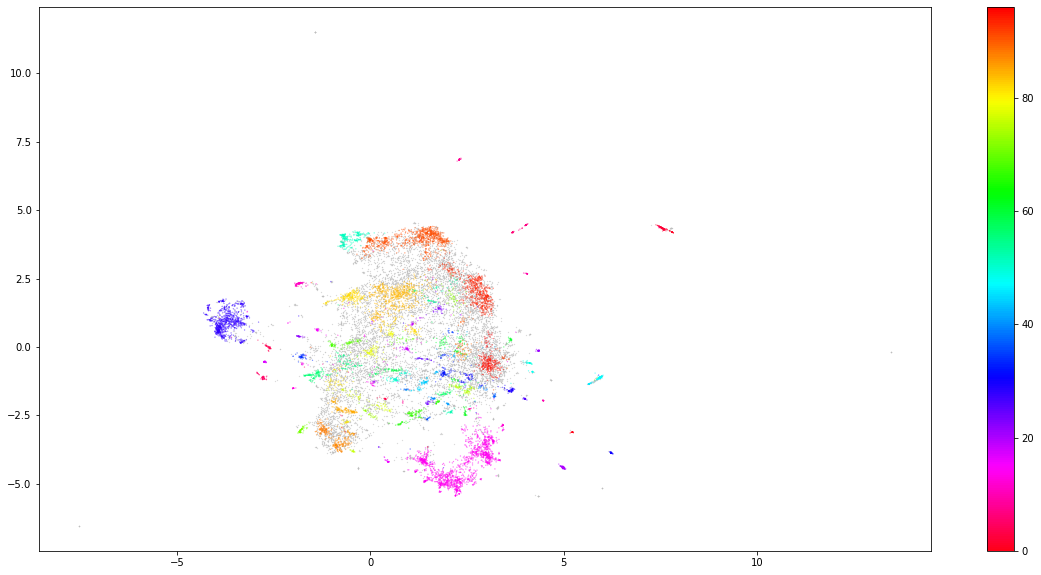

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

It is difficult to visualize the individual clusters due to the number of topics generated (~55). However, we can see that even in 2-dimensional space some local structure is kept.

NOTE: You could skip the dimensionality reduction step if you use a clustering algorithm that can handle high dimensionality like a cosine-based k-Means.

##**Topic Creation**
What we want to know from the clusters that we generated, is what makes one cluster, based on their content, different from another?

How can we derive topics from clustered documents?

To solve this, I came up with a class-based variant of TF-IDF (**c-TF-IDF**), that would allow me to extract what makes each set of documents unique compared to the other.

The intuition behind the method is as follows. When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.

What if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

**c-TF-IDF**

To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents:

In [ ]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


Then, we apply the class-based TF-IDF:

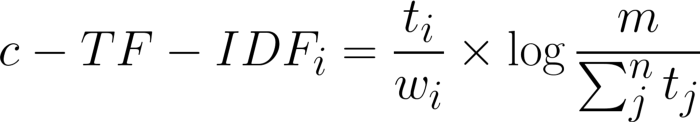

class-based TF-IDF by joining documents within a class. Image by the author.

Where the **frequency** of each word **t** is extracted for each class **i** and divided by the total number of words **w**. This action can be seen as a form of regularization of frequent words in the class. Next, the total, unjoined, number of documents **m** is divided by the total frequency of word t across all classes **n**.



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(newsgroups_train))

Now, we have a single importance value for each word in a cluster which can be used to create the topic. If we take the top 10 most important words in each cluster, then we would get a good representation of a cluster, and thereby a topic.

###**Topic Representation**
In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.



In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,9666
15,14,1637
92,91,876
29,28,840
85,84,628
95,94,507
83,82,277
52,51,249
96,95,248
88,87,144


We can use topic_sizes to view how frequent certain topics are:

In [ ]:
topic_sizes

,Topic,Size
0,-1,9666
15,14,1637
92,91,876
29,28,840
85,84,628
...,...,...
39,38,15
91,90,15
93,92,15
44,43,15


The topic name-1 refers to all documents that did not have any topics assigned. The great thing about HDBSCAN is that not all documents are forced towards a certain cluster. If no cluster could be found, then it is simply an outlier.

We can see that topics 7, 43, 12, and 41 are the largest clusters that we could create. To view the words belonging to those topics, we can simply use the dictionarytop_n_words to access these topics:

In [ ]:
top_n_words[7][:10]

[('kimata', 0.0003259661088132889),
 ('devadatta', 0.0003259661088132889),
 ('nehru', 0.0003259661088132889),
 ('mukutmoni', 0.0003259661088132889),
 ('ebutai', 0.0003259661088132889),
 ('avenil', 0.0003259661088132889),
 ('gb7', 0.0002862749755307898),
 ('163959', 0.0002862749755307898),
 ('97z5', 0.0002862749755307898),
 ('philadephia', 0.0002862749755307898)]

In [ ]:
top_n_words[43][:10]

[('consulier', 0.0008759949635508174),
 ('lbf', 0.0008759949635508174),
 ('outdoorsey', 0.0007693297860583653),
 ('750f', 0.0007693297860583653),
 ('ettore', 0.0007693297860583653),
 ('cvts', 0.0007693297860583653),
 ('morodor', 0.0007693297860583653),
 ('illegitamate', 0.0007693297860583653),
 ('preselected', 0.0007693297860583653),
 ('eb110', 0.0007693297860583653)]

In [ ]:
top_n_words[12][:10]

[('ladd', 0.0005439541299341972),
 ('tablehockey', 0.0005439541299341972),
 ('735151266', 0.0005439541299341972),
 ('3288', 0.0005439541299341972),
 ('061532', 0.0005439541299341972),
 ('27080', 0.0005439541299341972),
 ('23729', 0.0005439541299341972),
 ('044544', 0.0005439541299341972),
 ('734832476', 0.0005439541299341972),
 ('uicv', 0.0005439541299341972)]

In [ ]:
top_n_words[41][:10]

[('jews_', 0.0008607710022303008),
 ('a1k', 0.0008607710022303008),
 ('734058912', 0.0008607710022303008),
 ('22532', 0.0008607710022303008),
 ('1rhb0e', 0.0008607710022303008),
 ('_antiquities', 0.0008607710022303008),
 ('9ks', 0.0008607710022303008),
 ('c6bjyt', 0.0008607710022303008),
 ('025426', 0.0008607710022303008),
 ('misvms', 0.0008607710022303008)]

Looking at the largest four topics, I would say that these nicely seem to represent easily interpretable topics!

I can see sports, computers, space, and religion as clear topics that were extracted from the data.

#**Topic Reduction**
There is a chance that, depending on the dataset, you will get hundreds of topics that were created! You can tweak the parameters of HDBSCAN such that you will get fewer topics through its min_cluster_size parameter but it does not allow you to specify the exact number of clusters.

A nifty trick that Top2Vec was using is the ability to reduce the number of topics by merging the topic vectors that were most similar to each other.

We can use a similar technique by comparing the c-TF-IDF vectors among topics, merge the most similar ones, and finally re-calculate the c-TF-IDF vectors to update the representation of our topics:

In [ ]:
!pip install cosine_similarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

,Topic,Size
0,-1,9666
12,11,1653
73,72,876
26,25,840
67,66,628
75,74,522
65,64,292
41,40,284
76,75,268
70,69,183


Above, we took the least common topic and merged it with the most similar topic. By repeating this 19 more times we reduced the number of topics from **56** to **36!**

**NOTE:*** We can skip the re-calculation part of this pipeline to speed up the topic reduction step. However, it is more accurate to re-calculate the c-TF-IDF vectors as that would better represent the newly generated content of the topics. You can play around with this by, for example, update every n steps to both speed-up the process and still have good topic representations.

**TIP:** You can use the method described in this article (or simply use BERTopic) to also create sentence-level embeddings. The main advantage of this is the possibility to view the distribution of topics within a single document.

